In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import pandas as pd
import random
import scipy.linalg
import seaborn as sns
import time
from tqdm.notebook import tqdm
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh
%matplotlib inline



class Timer(object):
    def __enter__(self):
        self.t0 = time.time()
    def __exit__(self, exc_type, exc_val, exc_tb):
        print('[time spent: {time:.2f}s]'.format(time = time.time() - self.t0))


# path = 'result/remove_features'
# if not os.path.exists(path):
#     os.makedirs(path)


seed = 42
# for system_name in ['Rossler', 'Rabinovich Fabrikant','Lorenz']:
system_name = 'Rabinovich Fabrikant'
# system_name = 'Lorenz'

random.seed(seed) 
np.random.seed(seed)


mses = [[] for _ in range(3)]
dim=1
U0 = np.loadtxt('dataset/matlab_gendata/'+system_name+'.csv', delimiter=',').T[:dim]
U = U0 + np.random.randn(*U0.shape)*1e-3
U = np.atleast_2d(U)
num_prepare = 1000
train_start = num_prepare
num_train = 10000
val_start = num_prepare + num_train
num_val = 1000
test_start = num_prepare + num_train + num_val
num_test = 5000
print('dataset shape:', U.shape)


inSize = U.shape[0]
outSize = inSize  
resSize = 100
a = 0.9           # leaking rate
K = 0.99          # spectial redius
reg = 1e-6       # regularization coefficient 
input_scaling = 1


# generation of random weights
Win = (np.random.rand(resSize,1+inSize)-0.5) * input_scaling
W = np.random.rand(resSize,resSize)-0.5
largest_eigvals, _ = largest_eigsh(W@W.T, 1, which='LM')
rhoW = np.sqrt(largest_eigvals[0])
W = W/rhoW*(K-1+a)/a 
X = np.zeros((resSize,U.shape[1]))

x = np.zeros([resSize,1])

for t in tqdm(range(U.shape[1])):
    u = U[:,t:t+1]
    x = (1-a) * x + a * np.tanh( Win @ np.vstack((1,u)) + W @ x ) 
    X[:,t:t+1] = x

# offline train
U_train = U[:,train_start : train_start + num_train]
X_train = X[:,train_start : train_start + num_train]
Y_train = U[:,train_start + 1 : train_start + num_train + 1]
H = np.vstack((np.ones((1,X_train.shape[1])),X_train))

Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))
print('pre_output shape:', H.shape)
print('W_out shape:', Wout.shape)

print('train error:', np.average(np.square(Wout @ H - Y_train)))

dataset shape: (1, 20000)


  0%|          | 0/20000 [00:00<?, ?it/s]

pre_output shape: (101, 10000)
W_out shape: (1, 101)
train error: 4.207922147834556e-06


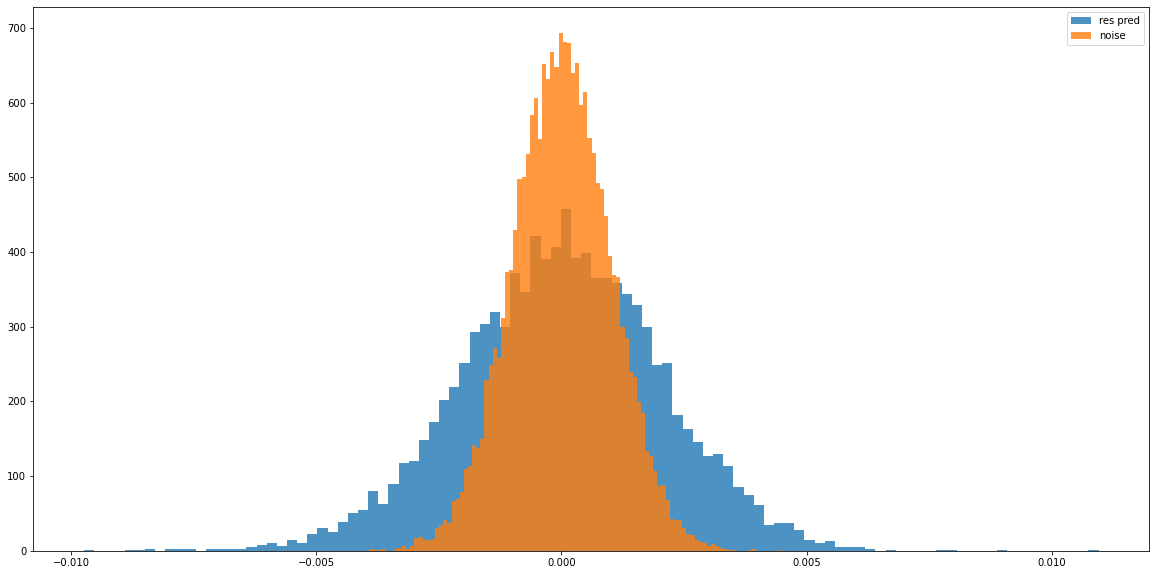

In [19]:

Res = Wout @ H - Y_train
# plt.figure(figsize=(20,10))
# _ = plt.plot(Res.T)
plt.figure(figsize=(20,10))
_ = plt.hist(Res.T,bins=100, alpha=0.8, label='res pred')

Res_U = U-U0
# plt.figure(figsize=(20,10))
_ = plt.hist(Res_U.T,bins=100,alpha=0.8, label = 'noise')
plt.legend()

In [5]:
print('train error:', np.average(np.square(Wout @ X_train - Y_train)))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1000 is different from 1001)

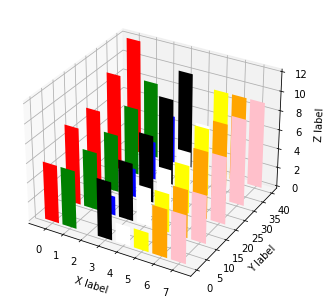

In [20]:
x = np.arange(8)
y = np.random.randint(0,10,8)
y2 = y + np.random.randint(0,3,8)
y3 = y2 + np.random.randint(0,3,8)
y4 = y3 + np.random.randint(0,3,8)
y5 = y4 + np.random.randint(0,3,8)
clr = ['red','green','blue','black','white','yellow','orange','pink']
fig = plt.figure()
ax = Axes3D(fig)
ax.bar(x,y,0,zdir='y',color=clr)
ax.bar(x,y2,10,zdir='y',color=clr)
ax.bar(x,y3,20,zdir='y',color=clr)
ax.bar(x,y4,30,zdir='y',color=clr)
ax.bar(x,y5,40,zdir='y',color=clr)
ax.set_xlabel('X label')
ax.set_ylabel('Y label')
ax.set_zlabel('Z label')
plt.show()

AttributeError: 'Patch3D' object has no property 'z'

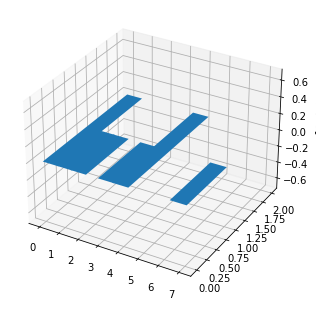

In [28]:
x = np.arange(8)
y = np.random.randint(0,10,8)
y2 = y + np.random.randint(0,3,8)
y3 = y2 + np.random.randint(0,3,8)
y4 = y3 + np.random.randint(0,3,8)
y5 = y4 + np.random.randint(0,3,8)
clr = ['red','green','blue','black','white','yellow','orange','pink']
fig = plt.figure()
ax = Axes3D(fig)
ax.hist(y,z=0,zdir='y')
ax.bar(x,y2,10,zdir='y')
ax.set_xlabel('X label')
ax.set_ylabel('Y label')
ax.set_zlabel('Z label')
plt.show()

In [22]:
y

array([6, 6, 0, 6, 2, 2, 5, 5])

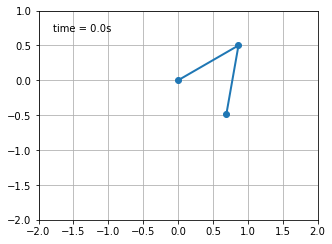

In [29]:
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

G = 9.8  # acceleration due to gravity, in m/s^2
L1 = 1.0  # length of pendulum 1 in m
L2 = 1.0  # length of pendulum 2 in m
M1 = 1.0  # mass of pendulum 1 in kg
M2 = 1.0  # mass of pendulum 2 in kg
t_stop = 5  # how many seconds to simulate


def derivs(state, t):

    dydx = np.zeros_like(state)
    dydx[0] = state[1]

    delta = state[2] - state[0]
    den1 = (M1+M2) * L1 - M2 * L1 * cos(delta) * cos(delta)
    dydx[1] = ((M2 * L1 * state[1] * state[1] * sin(delta) * cos(delta)
                + M2 * G * sin(state[2]) * cos(delta)
                + M2 * L2 * state[3] * state[3] * sin(delta)
                - (M1+M2) * G * sin(state[0]))
               / den1)

    dydx[2] = state[3]

    den2 = (L2/L1) * den1
    dydx[3] = ((- M2 * L2 * state[3] * state[3] * sin(delta) * cos(delta)
                + (M1+M2) * G * sin(state[0]) * cos(delta)
                - (M1+M2) * L1 * state[1] * state[1] * sin(delta)
                - (M1+M2) * G * sin(state[2]))
               / den2)

    return dydx

# create a time array from 0..100 sampled at 0.05 second steps
dt = 0.05
t = np.arange(0, t_stop, dt)

# th1 and th2 are the initial angles (degrees)
# w10 and w20 are the initial angular velocities (degrees per second)
th1 = 120.0
w1 = 0.0
th2 = -10.0
w2 = 0.0

# initial state
state = np.radians([th1, w1, th2, w2])

# integrate your ODE using scipy.integrate.
y = integrate.odeint(derivs, state, t)

x1 = L1*sin(y[:, 0])
y1 = -L1*cos(y[:, 0])

x2 = L2*sin(y[:, 2]) + x1
y2 = -L2*cos(y[:, 2]) + y1

fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 1))
ax.set_aspect('equal')
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


def animate(i):
    thisx = [0, x1[i], x2[i]]
    thisy = [0, y1[i], y2[i]]

    line.set_data(thisx, thisy)
    time_text.set_text(time_template % (i*dt))
    return line, time_text


ani = animation.FuncAnimation(
    fig, animate, len(y), interval=dt*1000, blit=True)
plt.show()